## Imports & Initializations

In [4]:
import os
import pickle
import json
import random
import numpy as np
!pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install torch_geometric -q
import torch_geometric
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch.utils.data.dataloader import default_collate
from torch.utils.data import random_split
import math
from torch_geometric.utils import to_dense_adj, add_self_loops
from torch_geometric.nn import global_mean_pool
import time

In [5]:
# set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
warnings.filterwarnings("ignore")
DATA_PATH = "done"

## Dataset Structure

In [6]:
def get_files_in_folder(folder_path):
    file_list = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            file_list.append(file_path)
    return file_list

# Replace 'folder_path' with the path to the folder you want to read files from
verilog_files = get_files_in_folder(DATA_PATH)
print(verilog_files)
print(len(verilog_files))


['done\\adder11.txt', 'done\\adder12.txt', 'done\\adder13.txt', 'done\\adder14.txt', 'done\\adder15.txt', 'done\\adder16.txt', 'done\\adder17.txt', 'done\\adder18.txt', 'done\\adder19.txt', 'done\\adder2.txt', 'done\\adder20.txt', 'done\\adder5.txt', 'done\\adder6.txt', 'done\\adder8.txt', 'done\\ALU10.txt', 'done\\ALU13.txt', 'done\\ALU14.txt', 'done\\ALU15.txt', 'done\\ALU2.txt', 'done\\ALU6.txt', 'done\\ALU7.txt', 'done\\ALU8.txt', 'done\\ALU9.txt', 'done\\and1.txt', 'done\\and10.txt', 'done\\and12.txt', 'done\\and13.txt', 'done\\and14.txt', 'done\\and15.txt', 'done\\and16.txt', 'done\\and17.txt', 'done\\and18.txt', 'done\\and19.txt', 'done\\and2.txt', 'done\\and20.txt', 'done\\and21.txt', 'done\\and23.txt', 'done\\and25.txt', 'done\\and26.txt', 'done\\and27.txt', 'done\\and28.txt', 'done\\and29.txt', 'done\\and3.txt', 'done\\and30.txt', 'done\\and6.txt', 'done\\and7.txt', 'done\\and8.txt', 'done\\and9.txt', 'done\\comparator1.txt', 'done\\comparator13.txt', 'done\\comparator14.txt'

In [7]:
# Shuffle the dataset in-place
random.shuffle(verilog_files)

In [9]:
def extracting_attributes(verilog_file):
    try:
        if os.path.isfile(verilog_file):
            with open(verilog_file, "r") as file:
                loaded_data = json.load(file)
                nodes = loaded_data[0]
                edges = loaded_data[1]
                # edge_atr = loaded_data[2]
                label = loaded_data[3]
                
                x = torch.tensor(nodes, dtype=torch.float)
                edge_index = torch.tensor(edges, dtype=torch.long)
                # edge_atr = torch.tensor(edge_atr, dtype=torch.long)
                y = torch.tensor(label, dtype=torch.float)
                num_nodes = x.size(0)
                # print(num_nodes)
                
                # Create batch assignment vector (assuming one graph per file)
                batch = torch.zeros(num_nodes, dtype=torch.long)
                # data = Data(x=x, edge_index=edge_index, edge_attr=edge_atr ,y = y, batch = batch)
                data = Data(x=x, edge_index=edge_index, y = y, batch = batch)
                return data
    
    except Exception as e:
        print(e)
        return e

# temp=extracting_attributes("./done/adder6.txt")
# temp

In [10]:
class VerilogDataset(Dataset):  # Using Dataset from torch_geometric
    def __init__(self, verilog_files):
        print(f"Loaded {len(verilog_files)} Verilog files.")
        self.verilog_files = verilog_files

    def __len__(self):
        return len(self.verilog_files)

    def __getitem__(self, idx):
        verilog_file = self.verilog_files[idx]
        data = extracting_attributes(verilog_file)
        return data

dataset = VerilogDataset(verilog_files)
print(len(dataset))

Loaded 314 Verilog files.
314


In [11]:
print(verilog_files[0])
print(dataset.verilog_files[0])

done\pe22.txt
done\pe22.txt


In [14]:
def are_all_data_objects_unique(dataset):
    data_objects = []
    for data in dataset:
        if data in data_objects:
            return False
        data_objects.append(data)
    return True

# Example usage:
is_unique = are_all_data_objects_unique(dataset)
if is_unique:
    print("All data objects are unique.")
else:
    print("Duplicate data objects found.")


All data objects are unique.


In [15]:
num = random.randint(0, len(verilog_files))
verilog_files[num]

'done\\xor10.txt'

6


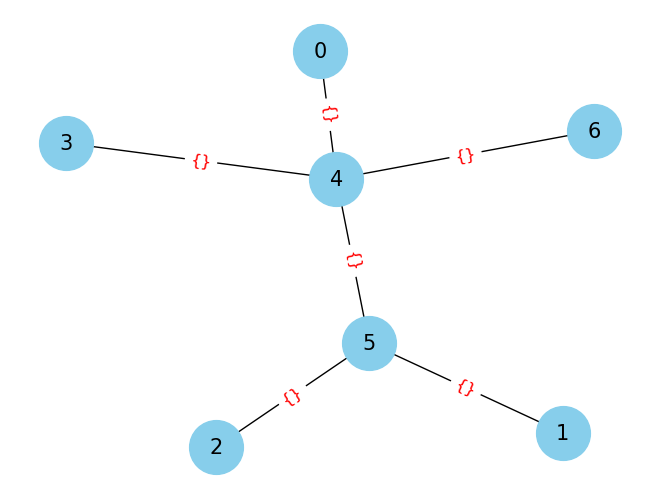

In [16]:
data = dataset[num]
data

g = nx.Graph()
g.add_nodes_from(range(data.num_nodes))
edges = data.edge_index.t().tolist()
# edge_attrs = {tuple(edge): attr.item() for edge, attr in zip(edges, data.edge_attr)}
g.add_edges_from(edges)
print(len(edges))

# Draw the graph with edge attributes
pos = nx.spring_layout(g)  # positions for all nodes
nx.draw(g, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='k', linewidths=1, font_size=15)
nx.draw_networkx_edge_labels(g, pos, font_color='red', font_size=12)  # Add edge labels
plt.show()

In [17]:
def graph_stat(dataset, verilog_files):
    """
    TODO: calculate the statistics of the ENZYMES dataset.
    
    Outputs:
        min_num_nodes: min number of nodes
        max_num_nodes: max number of nodes
        mean_num_nodes: average number of nodes
        min_num_edges: min number of edges
        max_num_edges: max number of edges
        mean_num_edges: average number of edges
    """
    # for ind,data in enumerate(dataset):
        # print(verilog_files[ind])
        # print(data)
        # print(len(data.x[1]))
        
    nodes_edges = [(data.num_nodes, data.num_edges) for data in dataset]
    num_nodes, num_edges = list(list(zip(*nodes_edges))[0]), list(list(zip(*nodes_edges))[1])
    min_num_nodes = min(num_nodes)
    max_num_nodes = max(num_nodes)
    mean_num_nodes = np.mean(num_nodes)
    min_num_edges = min(num_edges)
    max_num_edges = max(num_edges)
    mean_num_edges = np.mean(num_edges)
    mean_degree = (mean_num_edges)/mean_num_nodes
    
    print(f"min_num_nodes: {min_num_nodes}")
    print(f"max_num_nodes: {max_num_nodes}")
    print(f"mean_num_nodes: {mean_num_nodes}")
    print(f"min_num_edges: {min_num_edges}")
    print(f"max_num_edges: {max_num_edges}")
    print(f"mean_num_edges: {mean_num_edges}")
    print(f"mean nodes degree: {mean_degree}")

graph_stat(dataset, verilog_files)

min_num_nodes: 3
max_num_nodes: 165
mean_num_nodes: 15.006369426751592
min_num_edges: 2
max_num_edges: 208
mean_num_edges: 18.29299363057325
mean nodes degree: 1.2190152801358236


In [18]:
def custom_collate(batch):
    if isinstance(batch[0], Data):
        return batch
    else:
        return default_collate(batch)

In [19]:
# from torch.utils.data import random_split

# # Define the sizes of training, validation, and test sets
# train_size = int(0.7 * len(dataset))  # 70% of the data for training
# val_size = int(0.15 * len(dataset))   # 15% of the data for validation
# test_size = len(dataset) - train_size - val_size  # Remaining data for testing

# # Split the dataset into training, validation, and test sets
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# # Create DataLoader for each set
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=32)
# test_dataloader = DataLoader(test_dataset, batch_size=32)


# Define the size of the training set (e.g., 70% of the data)
train_size = int(0.7 * len(dataset))

# Calculate the size of the testing set
test_size = len(dataset) - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader for each set
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=custom_collate)


In [20]:
print(train_loader.dataset[0])

Data(x=[8, 20], edge_index=[2, 7], y=[1, 16], batch=[8])


In [23]:
loader_iter = iter(train_loader)
batch = next(loader_iter)
print(batch)

[Data(x=[16, 20], edge_index=[2, 19], y=[1, 16], batch=[16]), Data(x=[8, 20], edge_index=[2, 7], y=[1, 16], batch=[8]), Data(x=[25, 20], edge_index=[2, 26], y=[1, 16], batch=[25]), Data(x=[9, 20], edge_index=[2, 8], y=[1, 16], batch=[9]), Data(x=[29, 20], edge_index=[2, 50], y=[1, 16], batch=[29]), Data(x=[5, 20], edge_index=[2, 4], y=[1, 16], batch=[5]), Data(x=[7, 20], edge_index=[2, 6], y=[1, 16], batch=[7]), Data(x=[31, 20], edge_index=[2, 36], y=[1, 16], batch=[31]), Data(x=[13, 20], edge_index=[2, 15], y=[1, 16], batch=[13]), Data(x=[4, 20], edge_index=[2, 3], y=[1, 16], batch=[4]), Data(x=[10, 20], edge_index=[2, 9], y=[1, 16], batch=[10]), Data(x=[8, 20], edge_index=[2, 7], y=[1, 16], batch=[8]), Data(x=[22, 20], edge_index=[2, 21], y=[1, 16], batch=[22]), Data(x=[27, 20], edge_index=[2, 29], y=[1, 16], batch=[27]), Data(x=[3, 20], edge_index=[2, 2], y=[1, 16], batch=[3]), Data(x=[5, 20], edge_index=[2, 4], y=[1, 16], batch=[5])]


In [24]:
class GCNConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__()
        self.theta = nn.Parameter(torch.FloatTensor(in_channels, out_channels))
        # Initialize the parameters.
        stdv = 1. / math.sqrt(out_channels)
        self.theta.data.uniform_(-stdv, stdv)
    
    def forward(self, x, edge_index):
        """
        TODO:
            1. Generate the adjacency matrix with self-loop \hat{A} using edge_index.
            2. Calculate the diagonal degree matrix \hat{D}.
            3. Calculate the output X' with torch.mm using the equation above.
        """

        num_nodes = x.shape[0]
        A = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.shape[1]), (num_nodes, num_nodes))
        A = A.to_dense()
        A_hat = A + torch.eye(num_nodes)
        
        A_sum = torch.sum(A_hat, dim=1)
        D = torch.pow(A_sum, -0.5)
        D[D == float('inf')] = 0.0
        D_hat_sqrt = torch.diag(D)
        
        first = torch.mm(torch.mm(D_hat_sqrt, A_hat), D_hat_sqrt)
        second = torch.mm(x, self.theta)
        
        ret = torch.mm(first, second)
        
        return ret

In [25]:
# from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        """
        TODO:
            1. Define the first convolution layer using `GCNConv()`. Set `out_channels` to 64;
            2. Define the first activation layer using `nn.ReLU()`;
            3. Define the second convolution layer using `GCNConv()`. Set `out_channels` to 64;
            4. Define the second activation layer using `nn.ReLU()`;
            5. Define the third convolution layer using `GCNConv()`. Set `out_channels` to 64;
            6. Define the dropout layer using `nn.Dropout()`;

        """
        
        num_node_features = 20
        num_output_classes = 16
        
        # num_channels = 32
        
        self.gcn1 = GCNConv(in_channels=num_node_features, out_channels=128)
        self.a1 = nn.ReLU()
        self.gcn2 = GCNConv(in_channels= 128, out_channels=128)
        self.a2 = nn.ReLU()
        self.gcn3 = GCNConv(in_channels=128, out_channels=128)
        self.a3 = nn.ReLU()
        self.gcn4 = GCNConv(in_channels=128, out_channels=128)
        self.dropout = nn.Dropout(p=0.4)
        self.linear = nn.Linear(in_features=128, out_features=num_output_classes)

    def forward(self, x, edge_index, batch):
        """
            x: [num_nodes, 4], node features
            edge_index: [2, num_edges], edges
            edge_attrib : [num_edges, 1], edge attributes
            batch: [num_nodes], batch assignment vector which maps each node to its 
                   respective graph in the batch

        Outputs:
            probs: probabilities of shape (batch_size, 16)
        """
        x = self.gcn1(x, edge_index)
        x = self.a1(x)
        x = self.gcn2(x, edge_index)
        x = self.a2(x)
        x = self.gcn3(x, edge_index)
        x = self.a3(x)
        x = self.gcn4(x, edge_index)
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = self.linear(x)
        
        probs = torch.nn.functional.softmax(x, dim=-1)
        
        return probs
        
        
        
GCN()

GCN(
  (gcn1): GCNConv()
  (a1): ReLU()
  (gcn2): GCNConv()
  (a2): ReLU()
  (gcn3): GCNConv()
  (a3): ReLU()
  (gcn4): GCNConv()
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=128, out_features=16, bias=True)
)

In [29]:

gcn = GCN()

# print(gcn.parameters())
# optimizer
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)
# loss
criterion = torch.nn.CrossEntropyLoss()

out_y= []

out_labels = []
def train(train_loader):
    gcn.train()
    # print(gcn.parameters())
    for batch_data in train_loader:  # Iterate in batches over the training dataset.
        for data in batch_data:
            # print(data.x, data.edge_index, data.batch, data.y)
            out = gcn(data.x, data.edge_index, data.batch)
            # pred = out.argmax(dim=1)
            # pred_out = torch.tensor(pred, dtype=torch.float16)
            # print(out)
            # print(data.y)
            out_labels.append((out, data.y))
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        

testing_labels = []

def test(loader):
    gcn.eval()
    correct = 0
    for batch_data in loader:  # Iterate in batches over the training/test dataset.
        for data in batch_data:
            out = gcn(data.x, data.edge_index, data.batch)  
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            testing_labels.append(pred)
            y_label = (data.y.tolist())
            y_label = y_label[0].index(1.0)
            pred_label = (pred.tolist())[0]
            # print(pred_label)
            # print(y_label)
            if y_label == pred_label:
                correct += 1            
            # correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


# Start the timer
start_time = time.time()

# Your training code here
for epoch in range(200):
    train(train_loader)
    train_acc = test(train_loader)
    test_acc = test(train_loader)
    
    print(f'Epoch: {epoch + 1:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    



# End the timer
end_time = time.time()

# Calculate the duration
duration = end_time - start_time
print("Training duration:", duration, "seconds")

Epoch: 001, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 002, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 003, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 004, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 005, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 006, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 007, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 008, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 009, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 010, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 011, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 012, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 013, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 014, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 015, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 016, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 017, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 018, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 019, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 020, Train Acc: 0.0913, Test Acc: 0.0913
Epoch: 021, Train Acc: 0.0913, Test Acc:

KeyboardInterrupt: 

In [419]:
test_acc

0.1958762886597938

In [30]:
torch.save(gcn.state_dict(), 'gcn_model4.pth')

In [429]:
x = torch.tensor([[0,0,1], [0,0,1], [1,0,1], [3,3,1]], dtype=torch.float)
y = torch.tensor([2], dtype=torch.long)
edge_index = torch.tensor([[0, 1, 2],
                           [3, 3, 3]], dtype=torch.long)
gcn.eval()
batch = torch.tensor([0, 0, 0, 0], dtype=torch.long)
data_trial = Data(x=x, edge_index=edge_index, y=y, batch = batch)

out = gcn(data_trial.x, data_trial.edge_index, data_trial.batch)
pred = out.argmax(dim=1)
print(pred)

tensor([17])


In [ ]:
# gcn = GCN()
# gcn.load_state_dict(torch.load('gcn_model.pth'))

In [213]:
one_hot_list = torch.tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype = torch.long)  # Example one-hot encoded representation of class 2

# Get the index of the non-zero element
index = one_hot_list.index(1)

AttributeError: 'Tensor' object has no attribute 'index'

## Experiment 1


### Mode of Operation

* 321 verilog files 
* only 3 features             [type, operation_type, num_of_connections]
* no edge attribute
* 18 classes 
* 200 epochs 
* learning rate = 0.01
* Dropoout = 0.4
* Adam Optimizer
* train 70, test 30 (on whole dataset, not each class)
* time of training = seconds


### Results

* Train acc:  0.2902
* Test Acc: 0.1959


### Suggested Modifications for upcoming experiments

1) Clean dataset (by removing unnecessay, uninformative or wrong code files)
2) remove reduntant parsing (different files but same parsing)
3) include more informative features
4) improve encoding format
5) try using less classes (most important ones, so that less classes but more balanced dataset)
6) adding more files
7) adjusting hyperparameters such as learning rate, dropout, ...etc
8) splitting train, val, test
9) using equal percentages of each class (adjusting splitting)

## Experiment 2

### Mode of Operation

### Results

### Suggested Modifications for upcoming experiments

# Experiment 4

lr = 0.01

all 20 features 

dropout 0.4

train = 0.9 test = 0.9